# Homework 2 - FE621
Waldyr Faustini

In [254]:
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
tqdm.pandas() # for progress bars
pd.options.mode.chained_assignment = None  # default='warn'


C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Problem 1

## a) Build pricer

In [204]:
def euro_vanilla_pricer(N, T, S, K, r, sigma, option_type):
    
    # Trigeorgis 1992 coeffs
    dt = T/N
    nu = r - 0.5 * sigma**2
    dx_u = np.sqrt(sigma**2 * dt + nu**2 * dt**2)
    dx_d = - dx_u
    p_u = 0.5 * (1 + nu * dt/dx_u)
    p_d = 1 - p_u
    
    # one-period discount factor
    disc = np.exp(- r * dt)
    walk_up = np.exp(dx_u - dx_d)
    
    # initialize asset price at maturity, starting with the bottom one
    # we will use the convention that 0 denotes the lowest value
    ST = np.zeros(N+1)
    ST[0] = S * np.exp(N * dx_d)
    for i in range(1, N+1, 1):
        ST[i] = ST[i-1]*walk_up
    
    value = np.zeros(N+1)
    for j in range(N+1):
        if option_type == 'call':
            value[j] = max(ST[j] - K, 0)
        else: 
            value[j] = max(K - ST[j], 0)
            
    # now we just propagate back - since these are European options,
    # value at each node is just the propagated discounted expectation
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            value[j] = disc * (p_u * value[j+1] + p_d * value[j])
    
    return value[0]

**Test**: to see if this works, we check whether the put-call parity $$c(t) - p(t) = S(t) - K e^{-r(T-t)}$$ holds

In [205]:
call_price_eur = euro_vanilla_pricer(N=2000, T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='call')
print("Euro call price %.2f" % call_price_eur)

Euro call price 12.37


In [206]:
put_price_eur = euro_vanilla_pricer(N=2000, T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='put')
print("Euro put price %.2f" % put_price_eur)

Euro put price 11.37


In [207]:
# left-hand side
print(round(call_price_eur-put_price_eur,4))

# right-hand side
print(round(100 - 100 * np.exp(-0.01*1.0),4))

0.995
0.995


In [208]:
def american_vanilla_pricer(N, T, S, K, r, sigma, option_type):
    
    # Trigeorgis 1992 coeffs
    dt = T/N
    nu = r - 0.5 * sigma**2
    dx_u = np.sqrt(sigma**2 * dt + nu**2 * dt**2)
    dx_d = - dx_u
    p_u = 0.5 * (1 + nu * dt/dx_u)
    p_d = 1 - p_u
    
    # one-period discount factor and other constants
    disc = np.exp(- r * dt)
    walk_up = np.exp(dx_u - dx_d)
    d_p_u = disc * p_u
    d_p_d = disc * p_d
    edxd = np.exp(dx_d)
    
    # initialize asset price at maturity, starting with the bottom one
    # we will use the convention that 0 denotes the lowest value
    ST = np.zeros(N+1)
    ST[0] = S * np.exp(N * dx_d)
    for i in range(1, N+1, 1):
        ST[i] = ST[i-1]*walk_up
    
    value = np.zeros(N+1)
    for j in range(N+1):
        if option_type == 'call':
            value[j] = max(ST[j] - K, 0)
        else: 
            value[j] = max(K - ST[j], 0)
    
    # now we just propagate back, including the early stop condition
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            
            value[j] = d_p_d * value[j] + d_p_u * value[j+1]
            
            # however, there might be early exercise
            ST[j] = ST[j]/edxd
            
            if option_type == 'call':
                value[j] = max(value[j], ST[j] - K)
            else:
                value[j] = max(value[j], K - ST[j])
    
    return value[0]

**Test**: for an American call without dividends, its value should be the same as the equivalent European one (i.e. optimal exercise is at maturity)

In [209]:
call_price_amer = american_vanilla_pricer(N=2000, T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='call')
print("Call price (American): ", round(call_price_amer, 4))
print("Call price (European): ", round(call_price_eur, 4))

Call price (American):  12.3668
Call price (European):  12.3668


**Second test**: values for American puts should be greater or equal than the equivalent European option

In [210]:
put_price_amer = american_vanilla_pricer(N=2000, T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='put')
print("Put price (American): ", round(put_price_amer, 4))
print("Put price (European): ", round(put_price_eur, 4))

Put price (American):  11.4462
Put price (European):  11.3718


## 1.b

Reading back data from HW 1 (DATA2). Volatility was obtained in the `vol_bisect` column via the bisection method. Focus on Amazon data.

We will be using a yearly risk-free rate of 0.07% as taken from the previous assignment.

In [266]:
data = pd.read_csv('data_2.csv', index_col=0)
data = data[data['ticker'] == 'AMZN']

Ideally we would like to filter to maturities at 1, 2 and 3 months; since in HW1 we kept at those strictly less than 90 days away, we use ranges as proxy

We donwloaded the data around February 23, so let us extract maturities close to the third week of March, April and May

In [267]:
data = data[data['maturity'].isin(['2021-03-26', '2021-04-16', '2021-05-21'])]

Now remove data for options too deep in/out-of-the-money

In [268]:
data['dist_from_ATM'] = np.abs(data['strike'] - data['Close'])

In [269]:
data = data.sort_values(['maturity', 'dist_from_ATM'])

In [270]:
data = data.groupby('maturity').head(20)

In [271]:
# Check
data['maturity'].value_counts()

2021-03-26    20
2021-05-21    20
2021-04-16    20
Name: maturity, dtype: int64

Assuming European options:

In [272]:
data['binom_price_euro'] = data.progress_apply(lambda row: euro_vanilla_pricer(N=200, T=row['time_to_maturity'], S=row['Close'], K=row['strike'], r=0.07/100, sigma=row['vol_bisect'], option_type=row['type']),
           axis=1)

Assuming American options:

In [273]:
data['binom_price_amer'] = data.progress_apply(lambda row: american_vanilla_pricer(N=200, T=row['time_to_maturity'], S=row['Close'], K=row['strike'], r=0.07/100, sigma=row['vol_bisect'], option_type=row['type']),
           axis=1)

Reminder: Black-Scholes values are denoted as `calculated_price`

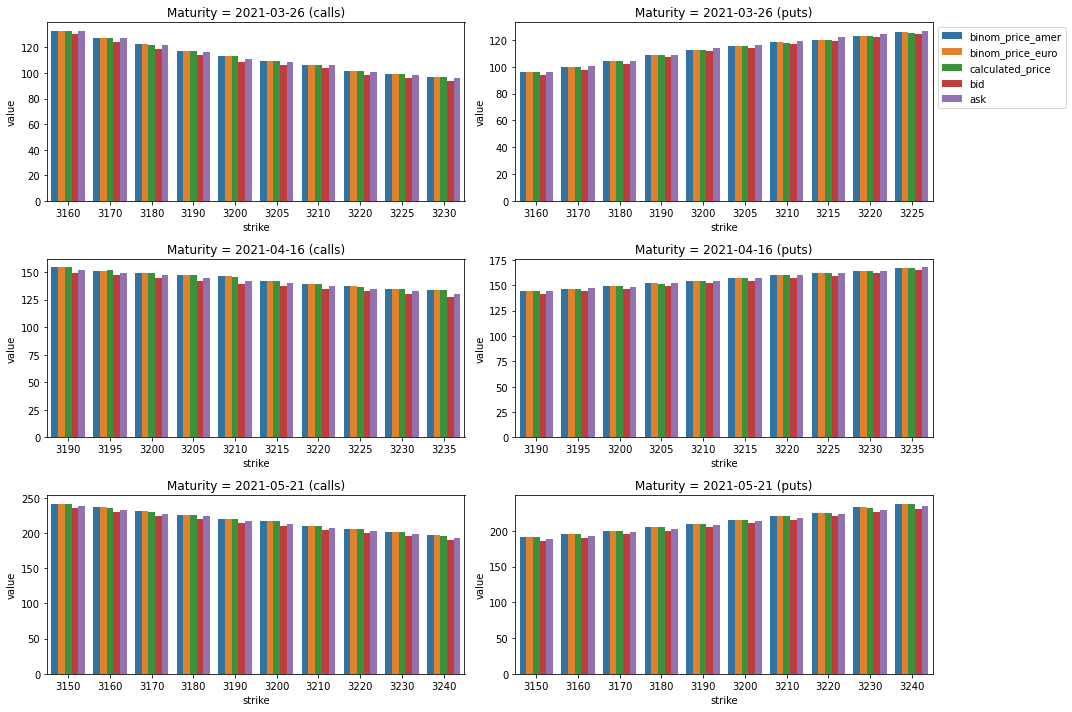

In [317]:
fig, ax = plt.subplots(figsize=(15,10), nrows=3, ncols=2)
data['strike'] = data['strike'].astype(int)
for i, maturity in enumerate(data['maturity'].unique()):
    aux_call = pd.melt(data[(data['maturity'] == maturity) & (data['type']=='call')],
            id_vars=['strike'], value_vars=['binom_price_amer', 'binom_price_euro', 'calculated_price', 'bid', 'ask'])
    aux_put = pd.melt(data[(data['maturity'] == maturity) & (data['type']=='put')],
            id_vars=['strike'], value_vars=['binom_price_amer', 'binom_price_euro', 'calculated_price', 'bid', 'ask'])

    # call options
    g = sns.barplot(
        data=aux_call, #kind="bar",
        x="strike", y="value", hue="variable", 
        ax=ax[i,0]
    )
    ax[i,0].get_legend().remove()
    ax[i,0].set_title(f"Maturity = {maturity} (calls)")
    
    # put options
    h = sns.barplot(
        data=aux_put, #kind="bar",
        x="strike", y="value", hue="variable", 
        ax=ax[i,1]
    )
    if i == 0:
        ax[i,1].legend(loc="upper left", bbox_to_anchor=(1, 1))
    else:
        ax[i,1].get_legend().remove()
        
    ax[i,1].set_title(f"Maturity = {maturity} (puts)")

plt.tight_layout()
plt.show()

## 1.c

* Models tend to replicate well the observed prices, but sometimes lie outside the bid/ask spread.
* No model tends to outperform the others, with all returning very similar prices.
* For shorter options, value as a function of strike has greater variance than for longer options

## d) Absolute errors

In [17]:
def bsm_euro_pricer(T, S, K, r, sigma, option_type, div=0):
    
    """
    Returns Black-Scholes formula 
    """
    from scipy import stats

    phi = 1 if option_type == "call" else -1
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0)
    d1 = 1 if T == 0 else (np.log(S/K) + (r - div + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return phi*(S * np.exp(-div*T) * N(phi*d1) - K * np.exp(-r*T) * N(phi*d2))

In [18]:
N_values = [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]

In [19]:
error =  [np.abs(bsm_euro_pricer(T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='put') 
               - euro_vanilla_pricer(N=N, T=1 , S=100, K=100, r=0.01, sigma=0.3, option_type='put')
               ) for N in tqdm(N_values)]

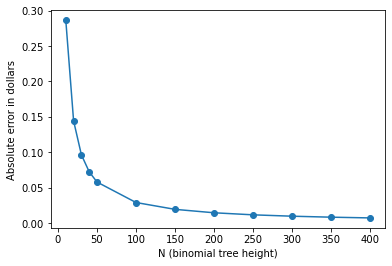

We observe, as expected, convergence towards the correct (BSM) value as N grows


In [20]:
plt.plot(N_values, error, marker='o')
plt.xlabel("N (binomial tree height)")
plt.ylabel("Absolute error in dollars")
plt.show()

print("We observe, as expected, convergence towards the correct (BSM) value as N grows")

# Exotic options using trinomial trees

## Trinomial tree for European up-or-out call option

Some considerations (call Clewlow, Les & Crickland (1996) simply the book, and the barrior option pricing as simply the paper):
* Firstly, the algorithm in the book works for American barrier options. This is made explicit when the early exercise feature is implemented in Algorithm 2.24 - thus, we need to remove it to make it European
* Secondly, we need to adapt Algorithm 3.3 from a simple European call into the barrier option
* Index ranges are from -N to N in Algo 3.3, for a total of 2N+1 indices. We will change this to adapt to Python logic into 0 to 2N by adding a constant of $N$ to every index iteration

The function below is generalized for European calls/puts, and both up-and-out and up-and-in barriers:

In [62]:
def euro_barrier_pricer_trinom(N, T, S, K, r, div, sigma, H, option_type, barrier_type):
    
    if barrier_type == 'uo':
        condition = lambda s, h: s <= h
    elif barrier_type == 'do':
        condition = lambda s, h: s >= h
        
    if option_type == 'call':
        payoff = lambda s, k: max(s-k, 0)
    elif option_type == 'put':
        payoff = lambda s, k: max(k-s, 0)
    
    # coefficients (from trinomal algo)
    dt = T/N
    nu = r - div - 0.5 * sigma**2
    dx = sigma * np.sqrt(3* dt) # optimal value
    edx = np.exp(dx)
    disc = np.exp(-r * dt)
    
    # probabilities (from trinomial algo)
    aux = (sigma**2 * dt + nu**2 * dt**2)/dx**2
    pu = 0.5 * (aux+ nu * dt/dx)
    pm = 1.0 - aux
    pd = 0.5 * (aux - nu * dt/dx)
    
    # to be able to properly evolve spot values back in time,
    ST = np.zeros(2*N+1)
    ST[0] = S*np.exp(-N*dx)
    
    for j in range(1, 2*N+1):
        ST[j] = ST[j-1]*edx

    # here we use a full grid for C instead of a vector    
    value = np.zeros((N+1, 2*N+1)) 

    for j in range(2*N+1):
        value[N, j] = payoff(ST[j], K) * condition(ST[j], H) 

    for i in range(N-1, -1, -1):
        for j in range(N-i, N+i+1):
            
            # since S(t)_j = S(t+delta t)_j, there is no need to bring S back in time
            value[i,j] = disc * (pu * value[i+1, j+1] + pm * value[i+1, j] + pd * value[i+1, j-1]) *  condition(ST[j], H) 

    return value[0,N]
    

**Test**: a barrier option must be less expensive than its vanilla counterpart, and the prices should converge (in the case of an up-and-out call) as $H \to \infty$. We show the plot below explicitly:

Using the values asked by the question statement:

In [51]:
H_list = range(10, 40, 1)
price_list = [euro_barrier_pricer_trinom(N=100, T=0.3, S=10, K=10, r=0.01, div=0.0, sigma=0.2, H=h,
                                        option_type='call', barrier_type='uo') for h in H_list]

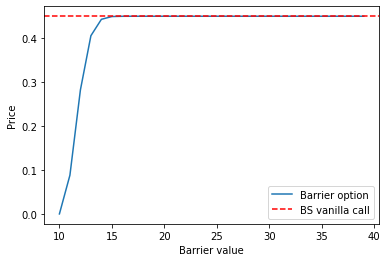

In [52]:
plt.plot(H_list, price_list, label='Barrier option')
plt.axhline(bsm_euro_pricer(T=0.3, S=10, K=10, r=0.01, sigma=0.2, option_type='call'), color='red', linestyle='--', label='BS vanilla call')
plt.xlabel("Barrier value")
plt.ylabel("Price")
plt.legend()
plt.show()

For the desired value of $H=11$:

In [64]:
print("Price: %.3f" % euro_barrier_pricer_trinom(N=1000, T=0.3, S=10, K=10, r=0.01, div=0.0, sigma=0.2, H=11,
                                                 option_type='call', barrier_type='uo'))

Price: 0.054


## b) Compare with theoretical result from Westermark's paper

In [58]:
def bsm_barrier_call_uo(T, S, K, r, div, sigma, H):
    from scipy import stats
    
    nu = r - div - 0.5*sigma**2  # d2 or d- in BSM
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0)
    d = lambda s, k : (np.log(s/k) + nu*T)/(sigma*np.sqrt(T))
    c = lambda s, k : bsm_euro_pricer(T=T, S=s, K=k, r=r, div=div, sigma=sigma, option_type='call')
    
    return (c(S,K) - c(S,H) - (H-K)*np.exp(-r*T) * N(d(S,H)) - \
            ((H/S)**(2*nu/sigma**2)) * (c(H**2/S, K) - c(H**2/S, H) - (H-K)*np.exp(-r*T)*N(d(H,S))))

In [65]:
print("Price: %.3f" % bsm_barrier_call_uo(T=0.3 , S=10, K=10, r=0.01, div=0.0, sigma=0.2, H=11))

Price: 0.053


Results are comparable!

## c) European up-and-in call

Using the analytical formula:

In [66]:
def bsm_barrier_call_ui(T, S, K, r, div, sigma, H):
    from scipy import stats
    
    nu = r - div - 0.5*sigma**2  # d2 or d- in BSM
    N = lambda x: stats.norm.cdf(x, loc=0.0, scale=1.0)
    d = lambda s, k : (np.log(s/k) + nu*T)/(sigma*np.sqrt(T))
    p = lambda s, k : bsm_euro_pricer(T=T, S=s, K=k, r=r, div=div, sigma=sigma, option_type='put')
    c = lambda s, k : bsm_euro_pricer(T=T, S=s, K=k, r=r, div=div, sigma=sigma, option_type='call')
    
    return (H/S)**(2*nu/sigma**2) * (p(H**2/S,K) - p(H**2/S,H) + (H-K)*np.exp(-r*T)*N(-d(H,S))) + \
            c(S,H) + (H-K)*np.exp(-r*T)*N(d(S,H))

In [67]:
print("Price: %.3f" % bsm_barrier_call_ui(T=0.3 , S=10, K=10, r=0.01, div=0.0, sigma=0.2, H=11))

Price: 0.398


Using in-out parity:

In [70]:
print("Price: %.3f" % (-bsm_barrier_call_uo(T=0.3 , S=10, K=10, r=0.01, div=0.0, sigma=0.2, H=11) + \
      bsm_euro_pricer(T=0.3 , S=10, K=10, r=0.01, div=0.0, sigma=0.2, option_type='call') ))

Price: 0.398


Again, perfect fit.

## d) American up-and-in put

For an European up-and-in put we could use the in-out parity as before.
However, for American options this is a highly non-trivial (non-Markovian) problem depending on the full trajectory of the underlying. Even with a Monte-Carlo approach we would have to use a criterion for early exercise.

# Effects of dividends

## a) Continuous dividends

We first need to create binomial tree with parameters consistent with the required ones. To avoid using $\sigma$ information, we just go with a multiplicative tree.

>Instead of returning the price, we return the stopping point

In [139]:
def binomial_american_continuous_dividend_exercise_time(N, T, S, K, r, div, option_type, u, d):
    
    def payoff(s):
        if option_type == 'call':
            return max(s-K, 0)
        else:
            return max(K-s, 0)

    # one-period discount factor and other constants
    dt = T/N
    p = (np.exp((r-div) * dt) - d)/(u-d)
    disc = np.exp(- r * dt)

    # initialize asset price at maturity, starting with the bottom one
    # we will use the convention that 0 denotes the lowest value
    ST = np.zeros(N+1)
    ST[0] = S * d**N
    for i in range(1, N+1, 1):
        ST[i] = ST[i-1]*(u/d)
    
    value = np.zeros(N+1)
    for j in range(N+1):
        value[j] = payoff(ST[j])
    
    # now we just propagate back
    exercise_time = N
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            
            value_candidate = p * value[j] + (1-p) * value[j+1]
            
            # however, there might be early exercise
            ST[j] = ST[j]/d
            early_exercise_value = payoff(ST[j])
            
            if value_candidate >= early_exercise_value:
                # no early exercise
                value[j] = value_candidate
            else:
                value[j] = early_exercise_value
                exercise_time = i

    return exercise_time

**Test**: for zero dividend we know that early exercise is worthless:

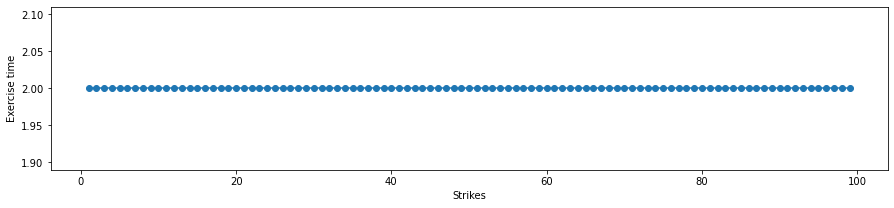

In [179]:
K_list = range(1, 100)
stop_times = [binomial_american_continuous_dividend_exercise_time(N=2, T=0.5, S=40, K=k, r=0.04, div=0.0, option_type='call', u=1.2, d=0.9)
              for k in K_list]
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(K_list, stop_times, marker='o')
ax.set_xlabel("Strikes")
ax.set_ylabel("Exercise time")
plt.show()

As we see $T=2$ always (which is expiry in a 2-period tree)

Testing now for the specified parameters:

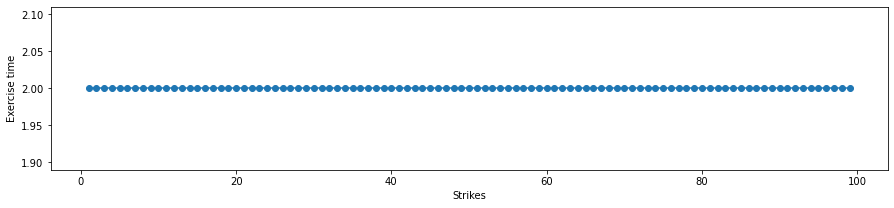

In [180]:
K_list = range(1, 100)
stop_times = [binomial_american_continuous_dividend_exercise_time(N=2, T=0.5, S=40, K=k, r=0.04, div=0.02, option_type='call', u=1.2, d=0.9)
              for k in K_list]
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(K_list, stop_times, marker='o')
ax.set_xlabel("Strikes")
ax.set_ylabel("Exercise time")
plt.show()

Still same result

## b) Discrete dividends at 3 months

We follow the presentation in Section 2.7 of the book.
To make matters simpler, we pre-compute all spot values

In [182]:
def binomial_american_proportional_dividend_exercise_time(N, T, S, K, r, prop_div, div_day, option_type, u, d):
    
    # div day must be an integer
    
    def payoff(s):
        if option_type == 'call':
            return max(s-K, 0)
        else:
            return max(K-s, 0)

    # one-period discount factor and other constants
    dt = T/N
    p = (np.exp(r * dt) - d)/(u-d)
    disc = np.exp(- r * dt)

    # evolve S considering the drop in price after dividends
    ST = np.zeros((N+1, N+1))
    for i in range(0, N+1):
        for j in range(i+1): 
            # for all dates equal or later than ex-dividend date, decrease by 1-div
            div_factor = 1 if i < div_day else (1-prop_div)
            ST[i, j] = div_factor * S * (u**(i-j)) * (d**j)
    
    # initialize values for the option
    value = np.zeros(N+1)
    for j in range(N+1):
        value[j] = payoff(ST[N, j])
    
    # now we just propagate back
    exercise_time = N
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            
            value_candidate = p * value[j] + (1-p) * value[j+1]
            
            # however, there might be early exercise
            early_exercise_value = payoff(ST[i,j])
            
            if value_candidate >= early_exercise_value:
                # no early exercise
                value[j] = value_candidate
            else:
                value[j] = early_exercise_value
                exercise_time = i

    return exercise_time

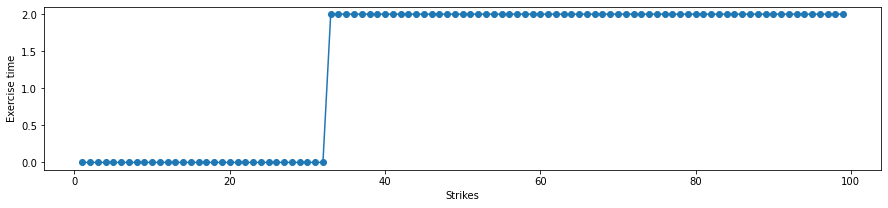

In [184]:
K_list = range(1, 100)
stop_times = [binomial_american_proportional_dividend_exercise_time(N=2, T=0.5, S=40, K=k, r=0.04, prop_div=0.03, div_day=1, option_type='call', u=1.2, d=0.9)
              for k in K_list]
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(K_list, stop_times, marker='o')
ax.set_xlabel("Strikes")
ax.set_ylabel("Exercise time")
plt.show()

We now see a new pattern - for sufficiently low strike prices (that is, when we are deep ITM) it is more worthy to exercise early

# Extra problem 2

First, we realize that in our constant-variance case, $P_{xy}(1)$ is fixed and will only depend on the points. Let $x = (x_i, x_j)$ and $y = (y_i, y_j)$. Then

$$P_{xy}(1) = \begin{cases}
p_u &\text{if}& x_i = y_i -1  &\text{and}& x_j = y_j - 1\\
p_m &\text{if}& x_i = y_i -1  &\text{and}& x_j = y_j    \\
p_d &\text{if}& x_i = y_i -1  &\text{and}& x_j = y_j +1  \\
0 &\text{otherwise}
\end{cases}$$

Let us denote these probabilities then as $P((i,j) \to (i+1, j'))$ where this number is not zero only for $j' \in \{j-1, j, j+1\}$.

The code in equations (15) and (16) can be greatly simplified in our case since we choose $\ell = 1$, because then no iteration over $j$ is needed. Let 

$$X[i,j] \equiv \log S_{ij}$$

Because we want a Varswap (with log returns), we choose $g_{log}$ as described in the text, for which (writing all functions as functions of $X[i,j]$):

$$\begin{align*}
h_1[i,j] &= 1\\
h_2[i,j] &= -2 X[i,j]\\
h_3[i,j] &= f_1[i,j] = X[i,j]^2\\
f_2[i,j] &= X[i,j]\\
f_3[i,j] &= 0
\end{align*}$$

With this in mind, we can translate the algorithm as: for $i$ in $\{n-1, n-2, \ldots, 0\}$ do:

$$\begin{align*}
A[i,j] &\leftarrow \sum_{j' \in \{j-1, j, j+1\}} P((i,j) \to (i+1, j')) h_1[i+1, j']\\
B[i,j] &\leftarrow \sum_{j' \in \{j-1, j, j+1\}} P((i,j) \to (i+1, j')) h_2[i+1, j']\\
C[i,j] &\leftarrow \sum_{j' \in \{j-1, j, j+1\}} P((i,j) \to (i+1, j')) (h_3[i+1, j'] + V[i+1, j'])\\
V[i,j] &\leftarrow A[i,j]f_1[i,j] + B[i,j] f_2[i,j] + C[i,j] + f_4[i,j]
\end{align*}$$



Because in our case $h_1 \equiv 1$, notice that all $A[i,j]$'s are identically equal to $p_u+p_m+p_d = 1$, which simplifies calculation a bit.

**OBS**: we will assume a notional of 1 and that we can calculate the value of the Varswap as 

$$\mathrm{value} = \frac{10000}{N_{days}} V_{0,0} - K;$$

if this is not the case please evaluate on the value of $V_{0,0}$ alone.

In [199]:
def varswap_pricer_trinom(N, T, S, r, div, sigma, K):
    
    # coefficients (from trinomal algo)
    dt = T/N
    nu = r - div - 0.5 * sigma**2
    dx = sigma * np.sqrt(3* dt) # optimal value
    edx = np.exp(dx)
    disc = np.exp(-r * dt)
    
    # probabilities (from trinomial algo)
    aux = (sigma**2 * dt + nu**2 * dt**2)/dx**2
    p_u = 0.5 * (aux+ nu * dt/dx)
    p_m = 1.0 - aux
    p_d = 0.5 * (aux - nu * dt/dx)
    
    X = np.zeros(2*N+1)
    X[0] = np.log(S) - N*dx
    
    for j in range(1, 2*N+1):
        X[j] = X[j-1] + dx

    # initialize matrices A=1, B, C, V
    B, C, V = np.zeros((N+1, 2*N+1)) , np.zeros((N+1, 2*N+1)) , np.zeros((N+1, 2*N+1)) 

    for i in range(N-1, -1, -1):
        for j in range(N-i, N+i+1):
            
            # since X(t)_j = X(t+delta t)_j, there is no need to bring S back in time
            B[i,j] = p_u * (-2 * X[j+1])            + p_m * (-2 * X[j])          + p_d * (-2 * X[j-1])
            C[i,j] = p_u * (X[j+1]**2 + V[i+1,j+1]) + p_m * (X[j]**2 + V[i+1,j]) + p_d * (X[j-1]**2 + V[i+1,j-1])
            V[i,j] = X[j]**2 + B[i,j] * X[j] + C[i,j]
            
    fair_strike = (100**2)*V[0,N]/N
    return V[0,N], fair_strike- K

In [200]:
v0, value = varswap_pricer_trinom(N=60, T=0.3, S=10, r=0.01, div=0, sigma=0.2, K=10)

In [201]:
print("V[0,0] = %.4f" % v0)

V[0,0] = 0.0120


In [202]:
print("Value = %.2f" % value)

Value = -8.00
